In [1]:
import os, glob, platform
import numpy as np
import numpy.matlib
import pickle
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import mat73
import mne
mne.__version__

'1.4.0'

In [2]:
path = 'decoding-toolbox_matlab/data/testdata_orientation.mat' 
ori_data = mat73.loadmat(path)
Y = ori_data['Y']
X = ori_data['X']
time = ori_data['time']
label = ori_data['label'] # Label of the features
X = X*(180./8)

In [3]:
import sys
path_utils = 'decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

In [4]:
EGG = True

subjs_list = ['s01'# , 's02'
              #, 's03' ,'s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' 
                ]
if EGG:
    
    path = 'Cond_CJ_EEG'

    epochs = []
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        epochs.append(epoch.average());
        # print(isubj)

    gvaverage = mne.grand_average(epochs[:])
    all_epochs = []
    all_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_rawdata[isubj] =  subj_data
        all_epochs.append(epoch);
        epoch.metadata
    all_st_epochs = []
    all_st_rawdata = [None] * np.size(subjs_list)
    for isubj, subject_id in enumerate(subjs_list):
        preproc_path = os.path.join(path, subject_id);
        epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)
        subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
        all_st_rawdata[isubj] =  subj_data
        all_st_epochs.append(epoch);
        epoch.metadata



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Identifying common channels ...


/var/folders/x2/l6kq7w2s48bbjcgczm1ll_fm0000gn/T/ipykernel_23472/297422856.py:17: RuntimeWarning: Only a single dataset was passed to mne.grand_average().
  gvaverage = mne.grand_average(epochs[:])


In [5]:
import DecToolbox as dt

0


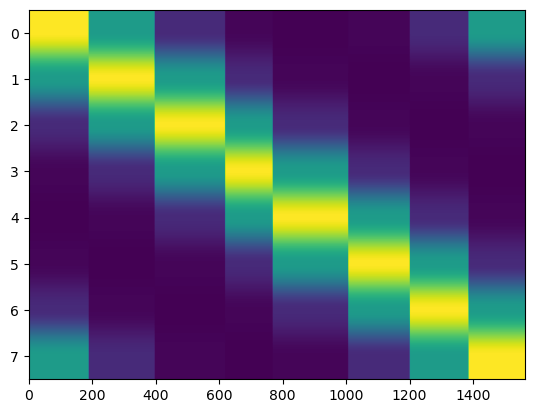

In [6]:
nSubj = np.size(subjs_list)

dec_subj = [None] * nSubj
G = [None] * nSubj

for ival, isubj in enumerate(subjs_list):
    print(ival)
    
    if EGG:
        time = all_st_epochs[ival].times
        label = all_st_epochs[ival].ch_names
        Y = all_st_rawdata[ival]['epoch_dat']
        Y = np.einsum('kji->jik', Y)
        X = np.array(all_st_rawdata[ival]['metadata'].orient)
    phi = X
    binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity
    # binned_phi = np.digitize(phi, bins = np.array([  0, 45, 90, 135 ]) ) # bins collapsing degrees by similarity

    numF = Y.shape[0];
    numT = Y.shape[1];
    numN = Y.shape[2];
    numC = 8 # how many channels to use
    G[ival] = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
    binned_phi = (G[ival]-1)*(180/8)
    
    CONDS = np.unique(G[ival])
    nConds = CONDS.size
    nfold = 4
    FoldsIdx = dt.CreateFolds(G[ival], Y, nfold)
    #numC = 8 # how many channels to use

    cfg = dict()
    cfg['kappa'] = 2
    cfg['NumC'] = numC
    cfg['Tuning'] = 'vonmises'#'halfRectCos'
    cfg['offset'] = 0

    design, sortedesign = dt.stim_features(binned_phi, cfg)
    
    plt.imshow(sortedesign, aspect = 'auto')

    Xhat = np.zeros([numC,numN, numT])
    for it in range(
        numT
        # 100,130
        ):
        cfg = dict()
        cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        cfg['cfgD'] = {'demean' : 'traindata'}
        Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)
    
    dec_subj[ival] = Xhat   

In [7]:
dec_subj[0].shape

(8, 1563, 201)

In [8]:
print(design.shape)

(8, 1563)


In [9]:
print(design[0])

[0.0698175  0.28717685 0.00944877 ... 0.51588541 0.0698175  0.28717685]


In [11]:
#print(stop)

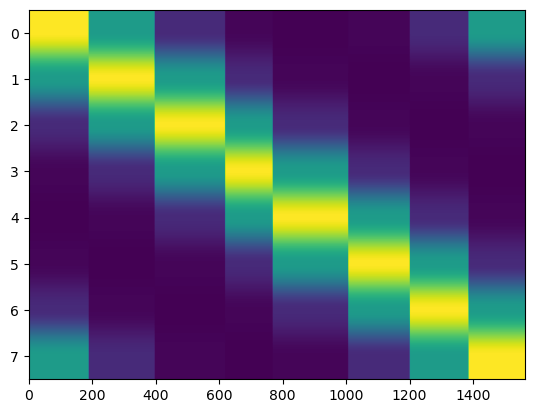

In [12]:
plt.imshow(sortedesign, aspect = 'auto')

In [13]:
m_centered = np.zeros((numC,numC, numT, nSubj))
for ival, isubj in enumerate(subjs_list):
    Zhat = dec_subj[ival]
    Zhat_centered = 0*Zhat.copy()
    
    for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
        Zhat_centered[:, G[ival] == (ic+1),:] = np.roll(Zhat[:,G[ival] == (ic+1),:], -ic, axis = 0)
        m_centered[:,ic, :, ival] =  np.mean( Zhat_centered[:,  G[ival] == (ic+1), :], axis = 1)

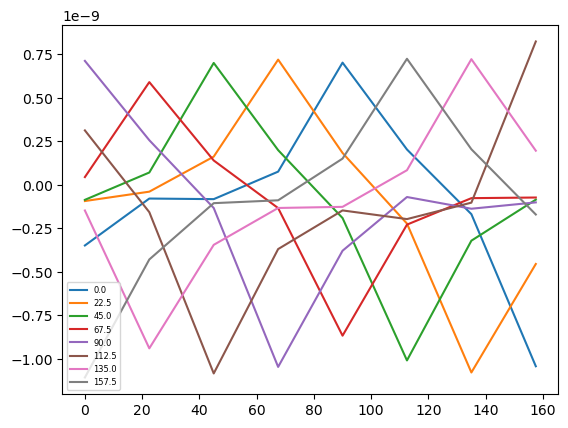

In [14]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
time_sett = 120
subject = 0


m = m_centered[:,:,time_sett,subject]
plt.plot(x_labels, m)
plt.legend(x_labels, loc=3, prop={'size': 6})

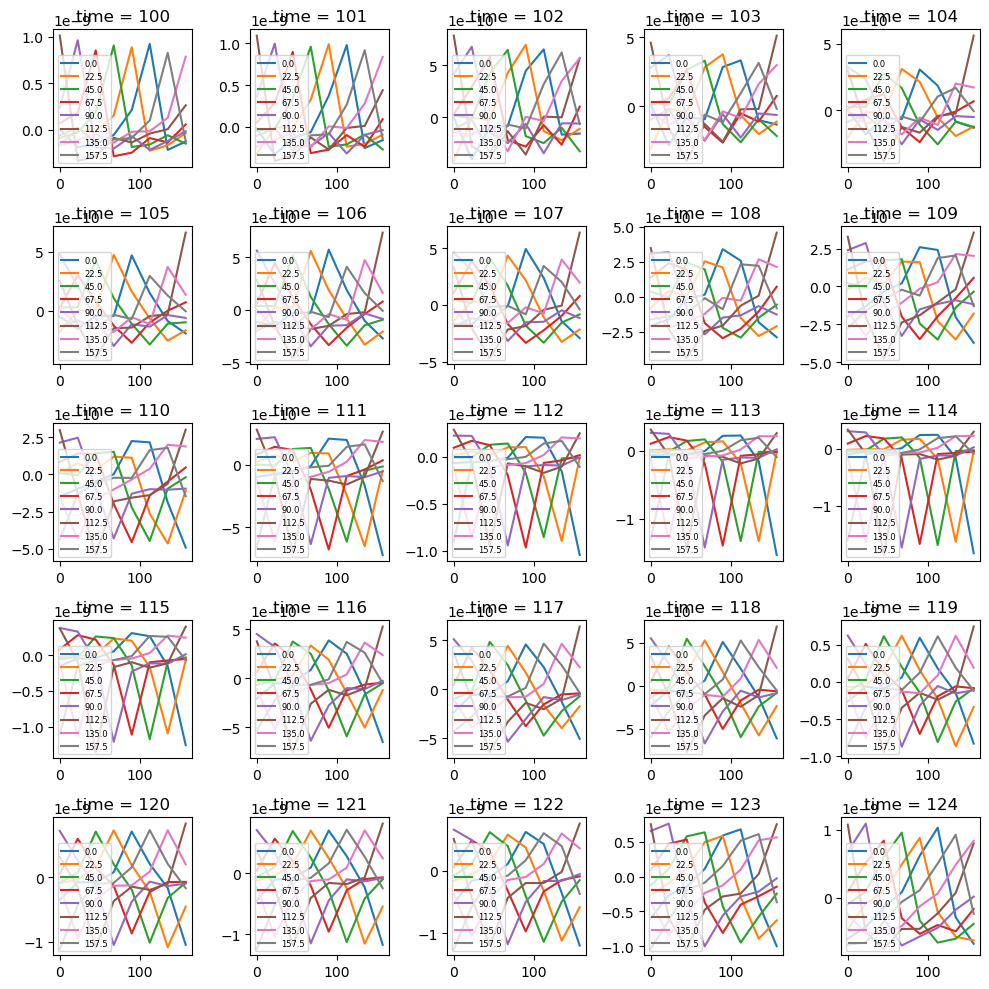

In [15]:

subject = 0
x_labels = np.array([0., 22.5, 45., 67.5, 90., 112.5, 135., 157.5])
time_sett_range = range(100, 125)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, time_sett in enumerate(time_sett_range):
    row = i // 5
    col = i % 5

    # Extract data for the specific subject and time_sett range
    m = m_centered[:, :, time_sett, subject]

    # Plot the data in the corresponding subplot
    axs[row, col].plot(x_labels, m)
    axs[row, col].set_title(f'time = {time_sett}')
    axs[row, col].legend(x_labels, loc=3, prop={'size': 6})

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
numT

211

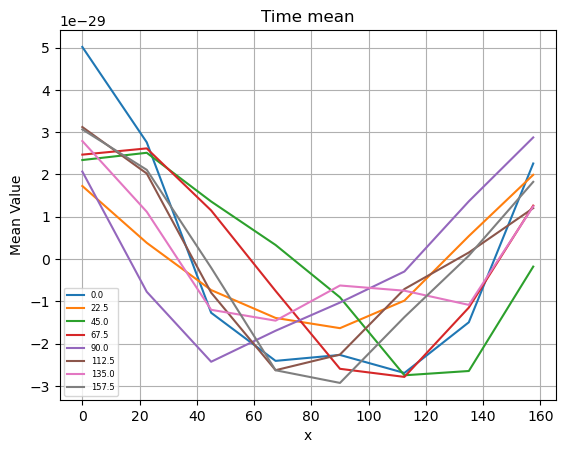

In [ ]:
subject = 0
time_sett_range = range(
    0
    , numT
    )

mean_data = np.mean(m_centered[:, :, time_sett_range, subject], axis=2)
plt.plot(x_labels, mean_data)
plt.xlabel('x')
plt.ylabel('Mean Value')
plt.title('Time mean')
plt.legend(x_labels, loc=3, prop={'size': 6})
plt.grid(True)

# Display the plot
plt.show()

IndexError: index 1 is out of bounds for axis 3 with size 1

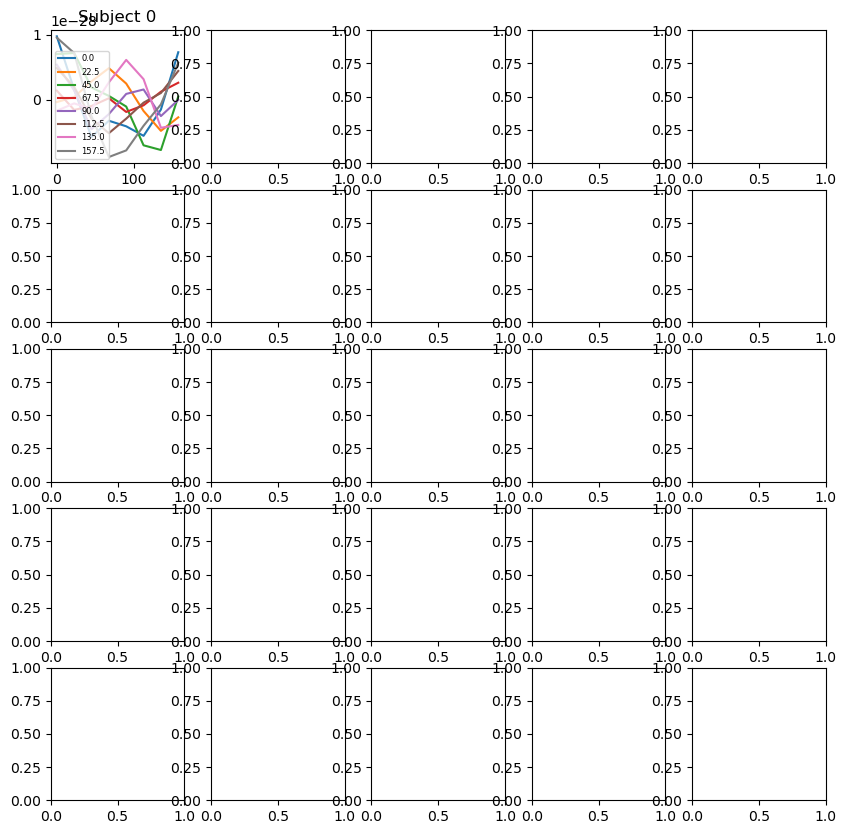

In [ ]:
x_labels = np.array([0., 22.5, 45., 67.5, 90., 112.5, 135., 157.5])
time_sett = 100

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for subject in range(25):
    row = subject // 5
    col = subject % 5

    # Extract data for the specific subject
    m = m_centered[:, :, time_sett, subject]

    # Plot the data in the corresponding subplot
    axs[row, col].plot(x_labels, m)
    axs[row, col].set_title(f'Subject {subject}')
    axs[row, col].legend(x_labels, loc=3, prop={'size': 6})

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


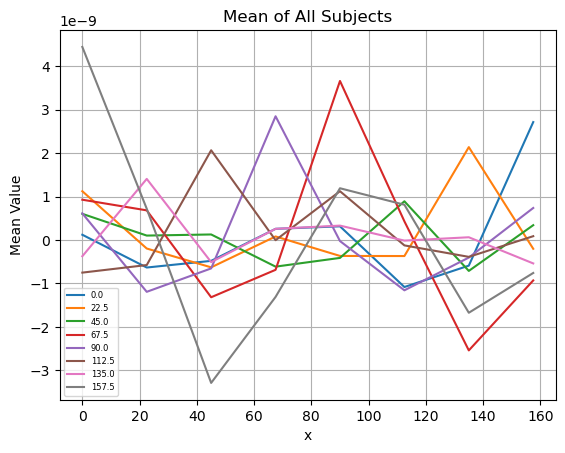

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = np.array([0., 22.5, 45., 67.5, 90., 112.5, 135., 157.5])
time_sett = 101

# Calculate the mean data for all subjects
mean_data = np.mean(m_centered[:, :, time_sett, :], axis=2)

# Plot the mean data
plt.plot(x_labels, mean_data)
plt.xlabel('x')
plt.ylabel('Mean Value')
plt.title('Mean of All Subjects')
plt.legend(x_labels, loc=3, prop={'size': 6})
plt.grid(True)

# Display the plot
plt.show()


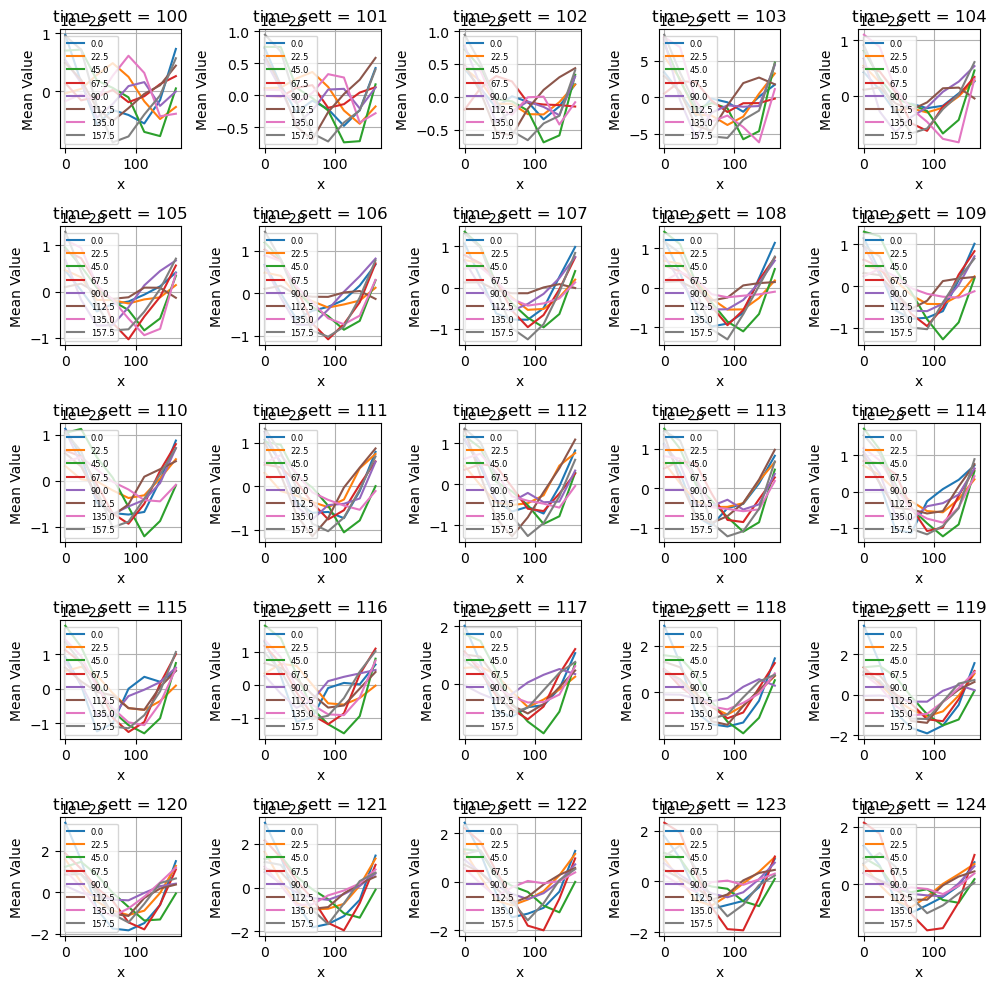

In [ ]:
x_labels = np.array([0., 22.5, 45., 67.5, 90., 112.5, 135., 157.5])
time_sett_range = range(100, 125)
subjects = range(25)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i, time_sett in enumerate(time_sett_range):
    row = i // 5
    col = i % 5

    # Calculate the mean data for all subjects for the specific time_sett
    mean_data = np.mean(m_centered[:, :, time_sett, :], axis=2)

    # Plot the mean data in the corresponding subplot
    axs[row, col].plot(x_labels, mean_data)
    axs[row, col].set_title(f'time_sett = {time_sett}')
    axs[row, col].set_xlabel('x')
    axs[row, col].set_ylabel('Mean Value')
    axs[row, col].legend(x_labels, loc=3, prop={'size': 6})
    axs[row, col].grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
print(plot)

NameError: name 'plot' is not defined

In [ ]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(C=1, solver='liblinear',
                                       multi_class='auto'))
time = all_st_epochs[ival].times
label = all_st_epochs[ival].ch_names
X = all_st_rawdata[ival]['epoch_dat'].mean(axis = 2)
#X = np.einsum('kji->jik', X)
Y = np.array(all_st_rawdata[ival]['metadata'].orient)

#binned_phi = np.digitize(Y, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity
binned_phi = np.digitize(Y, bins = np.array([  0, 45, 90, 135 ]) ) # bins collapsing degrees by similarity
G[ival] = binned_phi.copy()
Y = (G[ival]-1)*(180/4)
Y = Y.astype('str')
classes = set(Y)
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(Y), len(classes)))
for train, test in cv.split(X, Y):
    # Fit
    clf.fit(X[train], Y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])


In [ ]:
from sklearn.metrics import roc_auc_score

confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(Y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

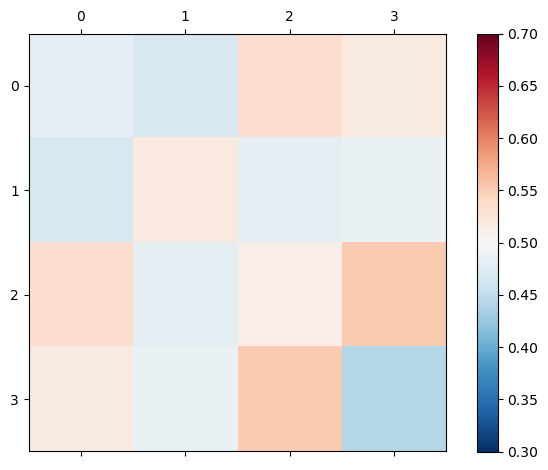

In [ ]:
#labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
#ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
#ax.set_xticklabels(labels, rotation=40, ha='left')
#ax.axhline(11.5, color='k')
#ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [ ]:
Zhat_centeredmean = np.mean( m_centered, axis = 1)
Zhat_centeredmean = np.mean( Zhat_centeredmean, axis = 2)

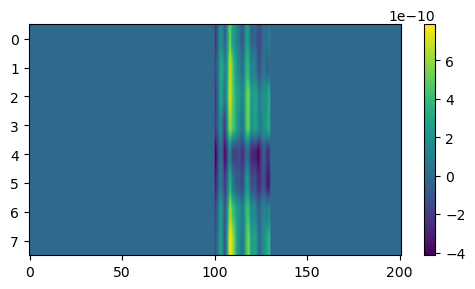

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Zhat_centeredmean,aspect='auto')
plt.colorbar()


In [ ]:
Zhat_centered.shape

(8, 1542, 201)

In [ ]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Zhat_centeredmean = np.mean(Zhat_centered, axis = 1)
#Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Zhat_shiftedmean = np.roll(Zhat_centeredmean, 3, axis = 0)
#Xhat_shiftedsem = np.roll(Zhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# plt.imshow(Zhat_centeredmean,aspect='auto', interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
# plt.colorbar()
# 